# Optimizing Weekly Fantasy Football Lineups

# Background and Motivation

Weekly fantasy sports have become incredibly popular in recent years - capitalizing on a landmark ruling allowing week to week sports betting on fantasy sports. Due to a landmark ruling by the Supreme Court that legalized sports betting which you can read more about [here](https://www.nytimes.com/2018/05/14/us/politics/supreme-court-sports-betting-new-jersey.html), millions of dollars have been won (and lost) on sites such as DraftKings and Fanduel. In weekly fantasy sports, your picks compete with everyone else who submits a lineup for that week. The element of competition makes finding an edge incredibly important when picking a lineup. But let's backtrack a second and answer a few essential questions.
    1. What is fantasy football? 
    2. What are DraftKings and FanDuel? 
    3. What is the object of weekly fantasy sports? 
    4. How is this relevant to data science? 

Let's address these questions. Fantasy football is a game in which participants select NFL players and gain points week to week based on the performance of the players in their lineup. Now, there's a distinction between conventional fantasy football and weekly fantasy football. Conventional fantasy football is played between 10 teams (usually) and each time has a different set of players on their team that they manage. Weekly fantasy football is an independent process. Each participant selects their optimal team from a pool of all available players given a certain budget they cannot exceed, a related cost for each player they add to their team, and a projection of how many points each player in their lineup will score in the coming week. You can read more about DraftKings and weekly fantasy football [here](https://www.draftkings.com). DraftKings and FanDuel are just two sites that host these weekly competitions, and in addition, they provide their own costs and projections that participants employ to create their weekly lineups. 

This is incredibly relevant to data science. Finding the edge that can create a better lineup than the next participant has a very real life reward (more money made on your bet), but could potentially be inferred from data available. Each player has their own statistical history. For example, Lamar Jackson (the current MVP favorite in the NFL) has statistics for each week of the 2019 season he has played. This past information can, with some likelihood, be used to assess how Jackson will play in the coming week. Moreover, creating the best lineup requires significant data analysis and knowledge of optimization. Optimization is at the very crux of machine learning and data science, as almost every problem can be broken down into an optimization of some loss function or objective. 

# Table of Contents

### 1. [Data Collection and Processing](#dcp)
### 2. [Data Visualization](#dv)
### 3. [Greedy Optimization](#go)
### 4. [Integer Programming Optimization](#ipo)
### 5. [Real-Life Analysis](#ra)
### 6. [Future Work](#fw)

# Pipeline

The pipeline for this project is as follows and occurs sequentially in this report: <br>
**Data Collection and Processing:** We need to set our column types, clean our columns, and remove missing values. <br>
**Data Visualization:** We visualize our data and derive a set of assumptions that we use to build our optimization models. <br>
**Greedy Optimization:** We implement our first optimization algorithm, which is a heuristic approximation for the optimal solution. <br>
**Integer Programming Optimization:** We use PuLP to implement an integer program, which fulfills optimality. <br>
**Sensitivity Analysis:** We analyze how our models perform in comparison. <br>
**Future Work:** We evaluate what further analyses could be explored. 

<a id="dcp"></a>
# Data Collection and Processing

So let's get started by scraping and collating the data such that we can run our optimization model end-to-end. In the world of fantasy football, the use of data to gain an edge is pretty well-defined. As such, fantasy football data and statistics are largely proprietary. Most websites allow public access to data through a csv, but scraping the data is a little more difficult. The data is mostly in tabular form, and is XML content, so parsing the data is more complicated. Rather than configuring our own XML parser, we can employ pandas to read this tabular data. 

For the purposes of our project and the specific optimization problem we are trying to solve, we need access to a set of fantasy-relevant players, their positions, the proprietary NumberFire projections and FanDuel projections, and the costs associated with acquiring each player. Let's get scraping!

In [2]:
import io, time, json
import requests
import pandas as pd
import collections
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import re
import lxml
from pulp import *

In [3]:
def get_fantasy_data(url):
    """ 
    Args: 
        url: String url that we want to parse for our information that we need. 
    Returns:
        fantasy_df: A dataframe that contains columns referring to our players, nf projections, fanduel projection, and costs. 
    """
    dfs = pd.read_html(url, header=0)
    players = []
    number_fire_projections = []
    fanduel_projections = []
    costs = []
    for df in dfs:
        if 'Player' in df.columns:
            players += list(df['Player'])
        if 'numberFire'in df.columns:
            number_fire_projections += list(df['numberFire'])[1:]
        if 'FanDuel' in df.columns:
            fanduel_projections += list(df["FanDuel"])[1:]
        if 'FanDuel.1' in df.columns:
            costs += list(df["FanDuel.1"])[1:]
    fantasy_df = pd.DataFrame({'players': players,
                              'nf_proj': number_fire_projections,
                              'fd_proj': fanduel_projections,
                              'costs': costs})
    return fantasy_df

     
url = 'https://www.numberfire.com/nfl/fantasy/fantasy-football-projections#_=_'
fantasy_data = get_fantasy_data(url)

Let's have a look at the data! 

In [4]:
fantasy_data.head()

,players,nf_proj,fd_proj,costs
0,"Lamar Jackson L. Jackson (QB, BAL)",23.64,24.33,$9000
1,"Patrick Mahomes P. Mahomes (QB, KC)",23.16,23.94,$8300
2,"Deshaun Watson D. Watson (QB, HOU)",21.39,22.16,$8200
3,"Russell Wilson R. Wilson (QB, SEA)",21.09,21.69,$8100
4,"Dak Prescott D. Prescott (QB, DAL)",20.11,20.84,$7800


This looks right. Great! We have matched each player with their corresponding numberFire projection, fanDuel projection and cost. We aren't done yet. We have all of our offensive player data. But a full DraftKings/weekly fantasy lineup includes 1 quarterback, 2 running backs, 3 wide receivers, 1 tight end and 1 defense. Let's get our defense data. Luckily, numberFire has projections and associated costs for all the defenses in the NFL. 

In [5]:
defense_url = "https://www.numberfire.com/nfl/fantasy/fantasy-football-projections/d"
defense_data = get_fantasy_data(defense_url)

In [6]:
defense_data.head()

,players,nf_proj,fd_proj,costs
0,"Philadelphia D/ST Philadelphia D/ST (D, PHI)",10.52,10.53,$4900
1,"Baltimore D/ST Baltimore D/ST (D, BAL)",9.94,10,$4800
2,"New England D/ST New England D/ST (D, NE)",9.61,9.6,$5000
3,"San Francisco D/ST San Francisco D/ST (D, SF)",9.16,9.2,$4500
4,New York Giants D/ST New York Giants D/ST (D...,9.10,9.14,$3900


So we have all the player data we need. But if we take a look at the dataframe, the first two changes we need to make are slightly obvious. The players column is misformatted. From this column of data, we need to infer the player's name, their corresponding position, and their team. The costs column also includes a '$' before all of our integer costs. A larger problem is that currently, our dataframe's columns are all panda object types. This is panda's equivalent of a string data type. Our columns nf_proj, fd_proj, and costs are numeric, however, and we need to convert our column types. Finally, we need to deal with missing/NA values. 

Among many solutions to parsing to the players column of our dataframe, we chose to utilize regex. We used panda's to_numeric function to cast our string columns to an integer type, and panda's string replace method to get rid of the '$' before each cost. 

We also define a new variable - value to price ratio. This is our projected score divided by our corresponding cost for each player. We wanted some way to conceptualize how valuable a player was - outside the player's raw point projection and associated cost. An informal way to view value to price ratio would be a player's "bang for your buck" i.e. how much value can you get with regards to the player's cost. This feature will form an important strategy that we use to rank players down the line. Rankings players by their pure projected points or their cost is short-sighted. To build the best team, we need a slightly more nuanced approach. We execute this approach by sorting our dataframe of players by value to price ratio. This will aid our greedy search as we can guarantee that any player we pick in sequential order will have the highest possible value to price ratio available


Given this information, let's implement all of this. 

In [7]:
def clean_line(line, position_list):
    line = line.split()
    for i in range(len(line[1:])):
        val = re.sub(r'[^a-zA-Z ]', '', line[1:][i])
        if val in position_list:
            position = val
            team = re.sub(r'[^a-zA-Z ]', '', line[1:][i+1])
    player = line[0] + " " + line[1]
    return player, position, team

def convert_types(df):
    numeric_cols = ["nf_proj", "fd_proj", "costs"]
    for col in df.columns:
        if col in numeric_cols:
            df[col] = pd.to_numeric(df[col])
    return df

def clean_dataframe(df, projection_type):
    all_player_data = list(df["players"])
    players = []
    positions = []
    teams = []
    position_list = ["QB", "RB", "TE", "WR"]
    for line in all_player_data:
        player, position, team = clean_line(line, position_list)
        players.append(player)
        positions.append(position)
        teams.append(team)
    df["player_id"] = players
    df["position"] = positions
    df["teams"] = teams
    df["costs"] = df["costs"].str.replace('$', '')
    df = convert_types(df)
    df["value_price_ratio"] = df[projection_type] / df["costs"]
    df.sort_values(by=['value_price_ratio'], inplace=True, ascending=False)
    df = df.dropna()
    df.reset_index()
    return df

                        
cleaned_data = clean_dataframe(fantasy_data, "nf_proj")

In [8]:
cleaned_data.head()

,players,nf_proj,fd_proj,costs,player_id,position,teams,value_price_ratio
1,"Patrick Mahomes P. Mahomes (QB, KC)",23.16,23.94,8300.0,Patrick Mahomes,QB,KC,0.002790
5,"Kyler Murray K. Murray (QB, ARI)",19.98,20.74,7600.0,Kyler Murray,QB,ARI,0.002629
0,"Lamar Jackson L. Jackson (QB, BAL)",23.64,24.33,9000.0,Lamar Jackson,QB,BAL,0.002627
2,"Deshaun Watson D. Watson (QB, HOU)",21.39,22.16,8200.0,Deshaun Watson,QB,HOU,0.002609
3,"Russell Wilson R. Wilson (QB, SEA)",21.09,21.69,8100.0,Russell Wilson,QB,SEA,0.002604


There we have it. We have our player_id column referring to the player in question. Our position and teams column refers to the player's position and their corresponding team. We also have our value to price metric, and our dataframe reflects a sorted order in terms of players that provide the best value for their cost. Awesome! Now we have to execute the same exact process for our defense dataframe, and sort that dataframe by the same value to price metric. 

In [9]:
def clean_defense_dataframe(df):
    all_defense_data = list(df["players"])
    position_list = ["D"]
    positions = []
    teams = []
    for line in all_defense_data:
        player, position, team = clean_line(line, position_list)
        positions.append(position)
        teams.append(team)
    df["position"] = positions
    df["player_id"] = teams
    df["costs"] = df["costs"].str.replace('$', '')
    df = convert_types(df)
    df["value_price_ratio"] = df["nf_proj"] / df["costs"]
    df.sort_values(by=['value_price_ratio'], inplace=True, ascending=False)
    df = df.dropna()
    df.reset_index()
    return df 

cleaned_defense_data = clean_defense_dataframe(defense_data)

In [10]:
cleaned_defense_data.head()

,players,nf_proj,fd_proj,costs,position,player_id,value_price_ratio
4,New York Giants D/ST New York Giants D/ST (D...,9.10,9.14,3900,D,NYG,0.002333
0,"Philadelphia D/ST Philadelphia D/ST (D, PHI)",10.52,10.53,4900,D,PHI,0.002147
1,"Baltimore D/ST Baltimore D/ST (D, BAL)",9.94,10.00,4800,D,BAL,0.002071
3,"San Francisco D/ST San Francisco D/ST (D, SF)",9.16,9.20,4500,D,SF,0.002036
6,"Pittsburgh D/ST Pittsburgh D/ST (D, PIT)",8.79,8.71,4400,D,PIT,0.001998


This looks good. Moving right along! At this point, we can merge our offensive and defensive data to create one cleaned dataset to work with.

In [115]:
def merge_data(clean_data, clean_d_data):
    combined = clean_data.append(clean_d_data, ignore_index=True, sort=False)
    return combined 

combined_cleaned_data = merge_data(cleaned_data, cleaned_defense_data)

In [116]:
combined_cleaned_data.head()

,players,nf_proj,fd_proj,costs,player_id,position,teams,value_price_ratio
0,"Patrick Mahomes P. Mahomes (QB, KC)",23.16,23.94,8300.0,Patrick Mahomes,QB,KC,0.002790
1,"Kyler Murray K. Murray (QB, ARI)",19.98,20.74,7600.0,Kyler Murray,QB,ARI,0.002629
2,"Lamar Jackson L. Jackson (QB, BAL)",23.64,24.33,9000.0,Lamar Jackson,QB,BAL,0.002627
3,"Deshaun Watson D. Watson (QB, HOU)",21.39,22.16,8200.0,Deshaun Watson,QB,HOU,0.002609
4,"Russell Wilson R. Wilson (QB, SEA)",21.09,21.69,8100.0,Russell Wilson,QB,SEA,0.002604


<a id="dv"></a>
# Data Visualization 

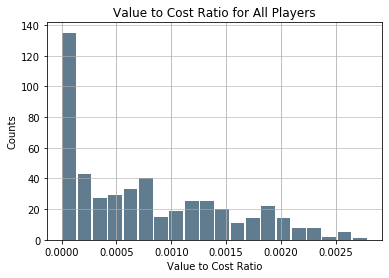

In [13]:
%matplotlib inline
def create_vpr_histogram(total_cleaned_data):
    vpr = total_cleaned_data["value_price_ratio"]
    vpr.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
    plt.title('Value to Cost Ratio for All Players')
    plt.xlabel('Value to Cost Ratio')
    plt.ylabel('Counts')
    plt.grid(axis='y', alpha=0.75)
    
create_vpr_histogram(combined_cleaned_data)

This histogram shows the distribution of value to price ratio for all players in the dataset. We can infer a few things from this histogram. First, most players in the dataset are - for our purposes - useless. The distribution is extremely right skewed implying that there are quite a few players who provide no value for their cost. Inversely, there are an extremely small number of players at the right tail of the distribution who provide a comparatively large value for their corresponding cost. This makes intuitive sense. Part of what makes managing a fantasy football team challenging is that there are very few players who are expected to perform very well. We can expect our right tail of the distribution to be small. Let's evaluate our value price ratio histograms by position.

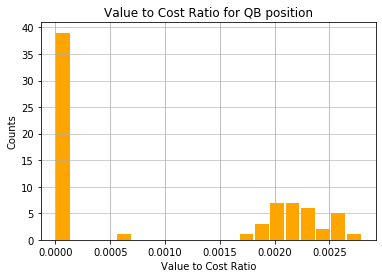

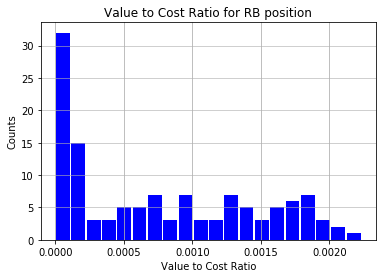

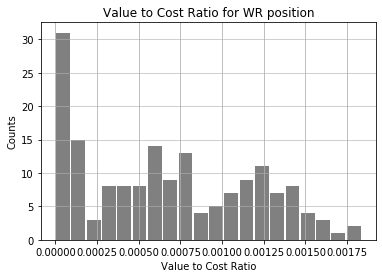

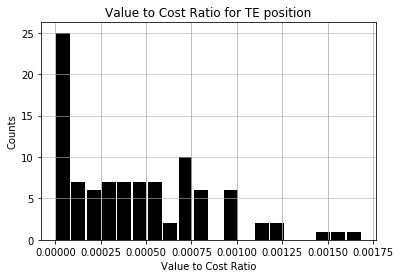

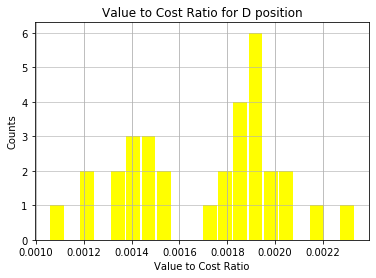

In [14]:
%matplotlib inline
def create_vpr_histogram_by_position(total_cleaned_data, position_list):
    color_list = ['orange', 'blue', 'gray', 'black', 'yellow']
    for position in range(len(position_list)): 
        subset = total_cleaned_data[total_cleaned_data["position"] == position_list[position]]["value_price_ratio"]
        plt.figure()
        subset.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color=color_list[position])
        plt.title('Value to Cost Ratio for %s position' % position_list[position])
        plt.xlabel('Value to Cost Ratio')
        plt.ylabel('Counts')
        plt.grid(axis='y', alpha=0.75)

position_list = ["QB", "RB", "WR", "TE", "D"]
create_vpr_histogram_by_position(combined_cleaned_data, position_list)

The disparity in terms of productive and non-productive players is extremely clear in our histogram of quarterbacks. Quarterbacks, in essence, are either expected to be unproductive for their acquisition cost or expected to be worth their acquisition cost. This is shown by two clear modes of the distribution. The same trend is present throughout our histograms by position, as we would expect, with varying numbers of players who provide middling value (bars in the middle of the distribution around the mean). However, there seems to be more variation for the defense position. Instead of two distinct sets of unproductive and productive players, there seems to be a larger number of defenses that provide middling value. It's possible that this occurs because more defenses provide similar value for similar costs. If there is less variation in defensive values and costs, we'd logically expect a cluster of defenses that provide around the same bang for your buck.

Our correlation coefficient between cost and value is 0.7487063628056032


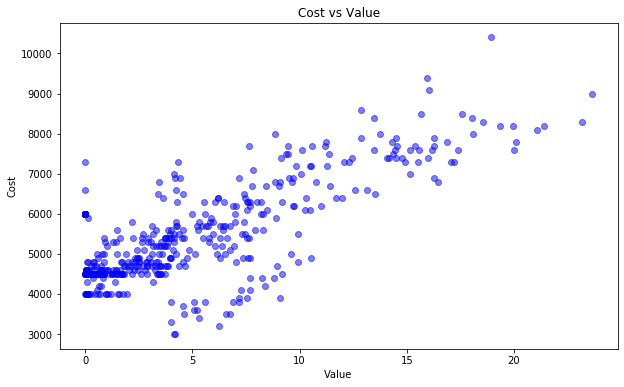

In [19]:
%matplotlib inline

def create_scatterplot(total_cleaned_data):
    plt.figure(figsize=(10,6))
    x = total_cleaned_data["nf_proj"]
    y = total_cleaned_data["costs"]
    r = np.corrcoef(x,y)[1][0]
    print("Our correlation coefficient between cost and value is %s" % r)
    plt.scatter(x, y, c="blue", alpha=0.5)
    plt.title('Cost vs Value')
    plt.xlabel('Value')
    plt.ylabel('Cost')
    plt.show()
    
create_scatterplot(combined_cleaned_data)

In this scatterplot, we evaluate the relationship between player value (projected points scored) and player cost. We'd expect this relationship to be linear. Logically, a player would have a higher acquisition cost if they are expected to be more statisticaly productive. Our scatterplot validates this notion, as it shows a mostly linear correlation. Our r correlation coefficient, which represents the strength and direction of the linear relationship between a covariate and a response variable shows a correlation of ~0.74, which indicates a somewhat strong positive linear relationship, as we would expect.

<a id="go"></a>
# Greedy Optimization

Let's take stock of where we are at this point. We have our cleaned data and an idea of the value to cost ratio for all of our players. Where do we go from here? Well, our original goal was to find a lineup of players that maximize our projected points scored under a cost constraint. This is the meat of our problem. 

An algorithm to solve this is fairly intuitive. First, we need a marker to tell us our cost of a lineup and points projected as we go about creating our lineup. To do this, we can create a class that represents a given team and write functions that keep track of the team's overall cost and overall points projected. To handle our lineup constraint, we can maintain a dictionary of the max number of players allowed at any given position and update a dictionary representing the number of players we have at each position as we add players to our roster. 

Our optimization principle is simple: we iterate through each player in our player list and take stock of the player's position and their cost. If our position constraint and cost constraint (i.e. if we add the player to our roster, our roster cost is less than our total cap) are fulfilled - then we add the player. We do this until we have a full roster of players. 

This optimization guideline is greedy - meaning we select the best player possible at every iteration (we can think of each iteration as considering to add a player or not). The key is, however, that it only works because we have pre-sorted our list of players by value price ratio. Hence, we select the best possible player at a given position. So we've explained the algorithm qualitatively, but for posterity, let's write this mathematically. 

Any optimization problem can be written as a maximization (or minimization) of some **objective function** with respect to a set of **constraints.** In this formulation, we will be using some specific notation. 

**1.** $p_i$ refers to the projected points associated with a specific player i. <br>
**2.** $c_i$ refers to the associated cost associated with a specific player i. <br>
**3.** $x_i$ refers to a binary variable that represents whether a player i is included in the lineup or not. <br>
**4.** $C$ refers to our budget that we have available to acquire players. 

**Our breakdown of the problem is as follows:** <br>

**<em>Objective function:</em>** <br>
Find the $argmax$ $ \Sigma{p_i * x_i} $ with respect to our constraints. <br>
   
**<em>Constraints:</em>** <br>
       **a.** $ \Sigma{c_i * x_i} <= C $ <br>
       **b.** The size of the set $s_i$ $\in$ $S_i$ where S is the set of positions in the lineup does not exceed our previously maximum allowed for a given position on our roster. 
       
We need to keep in mind that the greedy optimization we are implementing here is not necessarily an **optimal** solution, rather it is an optimization (we hope a decently good one). The problem we are solving here is quite similar to other known optimization problems. Perhaps most relevantly, our problem is analagous to approximating a solution to the bounded knapsack problem, which you can find more detail on [here](https://en.wikipedia.org/wiki/Knapsack_problem). 
       
Phew, that was a lot of detail! Let's dive into the implementation. Weekly fantasy football budgets usually range between 50,000 and 60,000. For the purposes of this implementation, let's work with 60,000 as a starting point. 

In [107]:
class Team:
    def __init__(self, player_list, df):
        self.player_list = player_list
        self.df = df
        self.players = []
        
    def return_cost(self):
        team_cost = 0
        for p in self.players: 
            p_cost = int(self.df[self.df["player_id"] == p]["costs"])
            team_cost += p_cost
        return team_cost
    
    def return_value(self):
        team_value = 0
        for p in self.players:
            p_value = int(self.df[self.df["player_id"] == p]["nf_proj"])
            team_value += p_value
        return team_value

def optimize(data, max_cost):
    max_allowed = {"QB": 1, "RB": 2, "WR": 3, "TE": 1, "D": 1}
    count_positions = {"QB": 0, "RB": 0, "WR": 0, "TE": 0, "D": 0}
    players = data["player_id"]
    roster = Team(list(players), data)
    for player in players:
        player_position = list(data[data["player_id"] == player]["position"])[0]
        player_cost = list(data[data["player_id"] == player]["costs"])[0]
        count_constraint = (count_positions[player_position] < max_allowed[player_position])
        cost_constraint = (roster.return_cost() + player_cost <= max_cost)
        if count_constraint == True and cost_constraint == True:
            roster.players.append(player)
            roster_count = count_positions[player_position]
            roster_count += 1
            count_positions[player_position] = roster_count
    players = roster.players
    cost = roster.return_cost()
    value = roster.return_value()
    print("-----")
    print("Roster:")
    for player in players:
        print(player)
    print("-----")
    print("Total projected points:", value)
    print("-----")
    print("Total cost:", cost)
   
    
max_cost = 60000.0
optimize(combined_cleaned_data, max_cost)

-----
Roster:
Patrick Mahomes
Saquon Barkley
Dalvin Cook
Tyreek Hill
Michael Thomas
Travis Kelce
Christian Kirk
NYG
-----
Total projected points: 119
-----
Total cost: 59400


Ok, not bad for an approximation for an optimal solution! Our total cost is 56,100 which is well within our cost bound. Our position constraint has been fulfilled as well, with one quarterbacks, two running backs, three wide receivers, one tight end and a defense filling out our lineup. Our value of our maximized objective function is 108. This is a decent starting point. For reference, a lineup that scores more than 100 points is generally a "winning" lineup in a standard scoring lineup. So greedily picking the best player in terms of value price ratio does decently well, let's see how the optimal solution performs.  

<a id="ipo"></a>
# Integer Programming Optimization

The formulation of the integer programming solution to our optimization problem is the same as our greedy optimization algorithm. However, we are using PuLP - a linear programming python library - that has built-in optimization solvers. The default solver for PuLP is CBC - which can you read more about [here](https://projects.coin-or.org/Cbc). PuLP also supports commercial optimization tools like Gurobi and others that typically work phenomenally well. For the purposes of this project, we will use CBC as our solver.  

There are a few nuances to using PuLP that are worth noting here. You can find the documentation for PuLP [here](https://pythonhosted.org/PuLP/). We need to encode our cost variable and point variables such that they reflect the maximization equation referenced earlier. We can take advantage of the LpVariable.dict function that converts a dictionary of values into an optimization equation in a format that can be utilized by PuLP's solver. To encode our positional constraints, we need to use a dictionary to keep track of when each position is filled. To navigate PuLP and to solve our positional constraint problem we found inspiration [here](https://medium.com/ml-everything/using-python-and-linear-programming-to-optimize-fantasy-football-picks-dc9d1229db81). 







In [110]:
import random
random.seed(685474) # set seed for reproducibility 

def alloc_costs_points(cleaned_data):
    costs = {}
    points = {}
    for pos in cleaned_data.position.unique():
        available_pos = cleaned_data[combined_cleaned_data.position == pos]
        cost = list(available_pos[["player_id","costs"]].set_index("player_id").to_dict().values())[0]
        point_val = list(available_pos[["player_id","nf_proj"]].set_index("player_id").to_dict().values())[0]
        costs[pos] = cost
        points[pos] = point_val
    return costs, points

def create_vars(points): 
    return {pos: LpVariable.dict(pos, points, cat="Binary") for pos, points in points.items()}

def optimize_optimal(costs, points, all_vars, max_allowed, max_cost):
    prob = LpProblem("Fantasy", LpMaximize)
    total_points = []
    total_costs = []
    position_constraints = []
    for k, v in all_vars_by_pos.items():
        total_costs += lpSum([costs[k][i] * all_vars[k][i] for i in v])
        total_points += lpSum([points[k][i] * all_vars[k][i] for i in v])
        prob += lpSum([all_vars[k][i] for i in v]) <= max_allowed[k]
    
    prob += lpSum(total_points)
    prob += lpSum(total_costs) <= max_cost
    prob.solve()
    return prob

costs, points = alloc_costs_points(combined_cleaned_data)
max_allowed = {"QB": 1, "RB": 2, "WR": 3, "TE": 1, "D": 1}
max_cost = 60000.0
all_vars_by_pos = create_vars(points)
prob = optimize_optimal(costs, points, all_vars_by_pos, max_allowed, max_cost)

def print_optimization(prob, costs_v):
    roster = []
    print("-----")
    print("Roster")
    for v in prob.variables():
        if v.varValue != 0:
            print(v.name, "=", v.varValue)
            roster.append(v.name.replace("_", " ")[2:].strip())
    total_costs = 0   
    for key in costs_v:
        values = costs_v[key]
        for player in values:
            if player in roster:
                total_costs += values[player]
    print("-----")
    print("Total projected points:", value(prob.objective))
    print("-----")
    print("Total cost:",  total_costs)

print_optimization(prob, costs)

-----
Roster
D_SF = 1.0
QB_Patrick_Mahomes = 1.0
RB_Dalvin_Cook = 1.0
RB_Saquon_Barkley = 1.0
TE_Travis_Kelce = 1.0
WR_Christian_Kirk = 1.0
WR_Michael_Thomas = 1.0
WR_Tyreek_Hill = 1.0
-----
Total projected points: 121.55
-----
Total cost: 60000.0


Our integer program shows slightly different results as compared to our greedy optimization. However, the results are quite similar as the two lineups differ in their choice of defense only. That shows that our greedy optimization was quite close to optimal. Picking players by their value to cost ratio seems to be a prudent way to form a DraftKings lineup. 

<a id="ra"></a>
# Real-Life Analysis

Awesome! So we have two optimization programs at this point. How do they compare? A disclaimer for this section is that since our scraper takes the most recent data from numberFire, the lineups we are analyzing may be out of date when this notebook is run. 
 
Our greedy optimized lineup is projected 119 points at a cost of 59,400. Our optimal lineup is projected 121.55 points, at a cost of 60,000. The optimal lineup is projected a couple more points than the greedy lineup, which is logical. So one of the great parts of this project is that it is super applicable to the real world. The greedy optimized lineup that we produced scored 98.3 points this past week in the NFL, while the optimal lineup scored 102.1 points. It's gratifying that this optimizer works well given that fantasy projections typically overvalue players. We would expect players to score less than they are projected - so the fact that our optimal produces a lineup that scored greater than 100 points under our cost constraint indicates the strength of our optimizer. 

<a id="fw"></a>
# Future Work 

Our work thus far has created useful and impactful results. Now we are able to, with up to date accuracy, predict an optimal lineup that pay actual dividends! This is something that creates very tangible value to sports bettors looking to gain an edge.

To further our work, we need to look further into simulations with multiple agents, where lineups are picked in a draft. This complicates our problem a bit more. All the work we have done so far only accounts for the spending methods of one agent. In a simulation, each agent will still try to pick the best lineup, but other agents will also try to have the best performing lineup. As a result, agents choosing optimal lineups would constantly need to be updating the dataset of available players. Additionally, aspects of this future project would need modifications to facilitate gameplay, so that human players can interact as one of the agents. 